<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/vgg_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

In [ ]:
import torch
import torch.nn as nn
import os
import copy
import torch.nn.functional as F
import torchaudio
import models
from torch.utils.data import DataLoader,random_split,Dataset
# from torch.optim import lr_scheduler
import torchvision
from utils import label_to_index, index_to_label, get_average_of_list
import utils
from dataset import SubsetSC
# import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
# from datetime import datetime

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

In [ ]:
torch.cuda.is_available()

False

**Pre-dataprocessing and data loading**

In [ ]:
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
train_dataset = SubsetSC("training", "old")
test_dataset = SubsetSC("testing", "old")

In [ ]:
#for benchmark training and validation data should be 
# combinaition of digits as well as new command
novel_data = ["follow"]
novel_train_dataset = SubsetSC("training", "novel", novel_data)
novel_test_dataset = SubsetSC("testing", "novel", novel_data)
train_dataset._walker += novel_train_dataset._walker
test_dataset._walker += novel_test_dataset._walker
digits += novel_data

In [ ]:

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(digits, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets


# old_traindata, old_testdata = torch.utils.data.random_split(old_data_set, [round(len(old_data_set)*.8), round(len(old_data_set)*.2)])
train_dataloader = DataLoader(train_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)

**Training for spoken digit recognizer**

In [ ]:
#log dict to save all records
log = []

In [ ]:

print("Initializing the neural network...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.VGGNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80,120,150], gamma=0.5)
# Training loop
num_epoch = 201
best_accuracy = 0.0
print("Started training !")
for epoch in tqdm(range(num_epoch), total=num_epoch, leave=False):
  running_loss = []
  train_accuracy = []

  for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'): 
    model.train()
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    logits = model(inputs) #batch_size x 14
    loss = F.cross_entropy(logits, labels)
    loss.backward() 
    optimizer.step()
    scheduler.step()
    running_loss.append(loss.item())
    _, pred = logits.max(1)
    acc = (pred == labels).sum().item() / pred.size(0) #pred size= [batch_size, no of classes] e.g(10,14)
    train_accuracy.append(acc)

  batch_train_loss = sum(running_loss)/len(running_loss)
  print(f'Epoch {epoch}/{num_epoch}... Loss: {batch_train_loss}')
  batch_train_accuracy = sum(train_accuracy)/len(train_accuracy)
  log.append({
      'mode': 'train',
      'epoch': epoch,
      'loss': batch_train_loss,
      'accuracy': batch_train_accuracy
      })

  # Evaluate the model on the test set every 10 epochs

  validation_loss = []
  validation_accuracy = []
  if epoch % 5 == 0:
    #validation loss and accuracy for novel classes
    with torch.no_grad():
      model.eval()
      for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'):
        inputs, labels = data[0].to(device), data[1].to(device)
        logits = model(inputs)
        loss = F.cross_entropy(logits,labels)
        validation_loss.append(loss.item())
        _, pred = logits.max(1)
        acc = (pred == labels).sum().item() / pred.size(0) #pred size= [batch_size, no of classes] e.g(10,14)
        validation_accuracy.append(acc)
      
      batch_validation_loss = sum(validation_loss)/len(validation_loss)
      print(f'Epoch {epoch}/{num_epoch}... Validation loss: {batch_validation_loss}')
      # writer.add_scalars('Loss', {'Test':batch_validation_loss}, epoch)
      # Saving model if accuracy on the test set is better than previous best model
      batch_val_accuracy = sum(validation_accuracy)/len(validation_accuracy)
      print(f'Epoch {epoch}/{num_epoch}... Accuracy: {batch_val_accuracy}')
      log.append({
      'mode': 'val',
      'epoch': epoch,
      'loss': batch_validation_loss,
      'accuracy': batch_val_accuracy
      })
      
      if batch_val_accuracy > best_accuracy:
          best_accuracy = batch_val_accuracy
          torch.save(model.state_dict(), 'checkpoint_vgg_benchmark.pth')
          torch.save(optimizer.state_dict(), 'optimizer_checkpoint_vgg_benchmark.pth')
          print(f'Best model saved at epoch {epoch}/{num_epoch}')

Initializing the neural network...
Device: cuda
Started training !


  0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 0/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0/201... Loss: 1.5268589378931583


Epoch: 0/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0/201... Validation loss: 0.9596614922795977
Epoch 0/201... Accuracy: 0.6641496598639457
Best model saved at epoch 0/201


Epoch: 1/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/201... Loss: 0.8866040787635705


Epoch: 2/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/201... Loss: 0.6560520217204705


Epoch: 3/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/201... Loss: 0.5432917166978884


Epoch: 4/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4/201... Loss: 0.47615544987030517


Epoch: 5/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5/201... Loss: 0.41862539515281333


Epoch: 5/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5/201... Validation loss: 0.33393844146104085
Epoch 5/201... Accuracy: 0.8920748299319727
Best model saved at epoch 5/201


Epoch: 6/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6/201... Loss: 0.38140278114722326


Epoch: 7/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7/201... Loss: 0.3613494460399334


Epoch: 8/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8/201... Loss: 0.3286821283209018


Epoch: 9/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9/201... Loss: 0.30714359377057127


Epoch: 10/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10/201... Loss: 0.28499091122394954


Epoch: 10/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10/201... Validation loss: 0.23560788109898567
Epoch 10/201... Accuracy: 0.922312925170068
Best model saved at epoch 10/201


Epoch: 11/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 11/201... Loss: 0.2699914254439183


Epoch: 12/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12/201... Loss: 0.25705183104444773


Epoch: 13/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13/201... Loss: 0.24186580823018


Epoch: 14/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14/201... Loss: 0.22799380264985256


Epoch: 15/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15/201... Loss: 0.21609276221253168


Epoch: 15/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15/201... Validation loss: 0.1721731193718456
Epoch 15/201... Accuracy: 0.9435034013605443
Best model saved at epoch 15/201


Epoch: 16/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16/201... Loss: 0.2055455149557346


Epoch: 17/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17/201... Loss: 0.19818296980781433


Epoch: 18/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18/201... Loss: 0.188284935687597


Epoch: 19/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19/201... Loss: 0.18035684105677482


Epoch: 20/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20/201... Loss: 0.16716559069852036


Epoch: 20/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 20/201... Validation loss: 0.18193656968928518
Epoch 20/201... Accuracy: 0.938673469387755


Epoch: 21/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 21/201... Loss: 0.1650495162568031


Epoch: 22/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 22/201... Loss: 0.15613151446749002


Epoch: 23/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 23/201... Loss: 0.14826444806769873


Epoch: 24/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 24/201... Loss: 0.14464736385032154


Epoch: 25/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 25/201... Loss: 0.13884069512192254


Epoch: 25/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 25/201... Validation loss: 0.12296587580238424
Epoch 25/201... Accuracy: 0.9576190476190476
Best model saved at epoch 25/201


Epoch: 26/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 26/201... Loss: 0.1309381312905596


Epoch: 27/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 27/201... Loss: 0.12216851474382938


Epoch: 28/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 28/201... Loss: 0.11944563180112686


Epoch: 29/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 29/201... Loss: 0.11297099928204447


Epoch: 30/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 30/201... Loss: 0.11061466969788457


Epoch: 30/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 30/201... Validation loss: 0.07112789570930458
Epoch 30/201... Accuracy: 0.9769047619047617
Best model saved at epoch 30/201


Epoch: 31/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 31/201... Loss: 0.09871875403377299


Epoch: 32/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 32/201... Loss: 0.0979705806188763


Epoch: 33/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 33/201... Loss: 0.09639400736404917


Epoch: 34/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 34/201... Loss: 0.08910846887633969


Epoch: 35/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 35/201... Loss: 0.0832195070440857


Epoch: 35/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 35/201... Validation loss: 0.07192070462874003
Epoch 35/201... Accuracy: 0.9745238095238093


Epoch: 36/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 36/201... Loss: 0.08042600904710782


Epoch: 37/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 37/201... Loss: 0.07675568713591649


Epoch: 38/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 38/201... Loss: 0.07431896770229707


Epoch: 39/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 39/201... Loss: 0.07352249465512638


Epoch: 40/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 40/201... Loss: 0.06657537678973033


Epoch: 40/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 40/201... Validation loss: 0.08540337914157481
Epoch 40/201... Accuracy: 0.9675510204081631


Epoch: 41/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 41/201... Loss: 0.06640180761628121


Epoch: 42/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 42/201... Loss: 0.05974557358974543


Epoch: 43/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 43/201... Loss: 0.05800251765296054


Epoch: 44/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 44/201... Loss: 0.055035964865122036


Epoch: 45/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 45/201... Loss: 0.049888829243644024


Epoch: 45/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 45/201... Validation loss: 0.029787824786451114
Epoch 45/201... Accuracy: 0.9904761904761903
Best model saved at epoch 45/201


Epoch: 46/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 46/201... Loss: 0.05135707889791005


Epoch: 47/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 47/201... Loss: 0.04798299494559148


Epoch: 48/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 48/201... Loss: 0.04643781703287879


Epoch: 49/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 49/201... Loss: 0.04496873325910061


Epoch: 50/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 50/201... Loss: 0.04403078125891252


Epoch: 50/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 50/201... Validation loss: 0.024722906001400025
Epoch 50/201... Accuracy: 0.9940476190476191
Best model saved at epoch 50/201


Epoch: 51/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 51/201... Loss: 0.03737891041912521


Epoch: 52/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 52/201... Loss: 0.04526002566395992


Epoch: 53/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 53/201... Loss: 0.03471621208651087


Epoch: 54/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 54/201... Loss: 0.03651941977978612


Epoch: 55/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 55/201... Loss: 0.02971550051170664


Epoch: 55/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 55/201... Validation loss: 0.010994758039790517
Epoch 55/201... Accuracy: 0.997619047619048
Best model saved at epoch 55/201


Epoch: 56/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 56/201... Loss: 0.027635773406244624


Epoch: 57/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 57/201... Loss: 0.03171407438438529


Epoch: 58/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 58/201... Loss: 0.027479947252551283


Epoch: 59/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 59/201... Loss: 0.02583998279141013


Epoch: 60/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 60/201... Loss: 0.02656838464198443


Epoch: 60/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 60/201... Validation loss: 0.0075602239830048
Epoch 60/201... Accuracy: 0.9988095238095237
Best model saved at epoch 60/201


Epoch: 61/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 61/201... Loss: 0.026497034914791585


Epoch: 62/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 62/201... Loss: 0.02286068512528287


Epoch: 63/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 63/201... Loss: 0.02267784641269081


Epoch: 64/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 64/201... Loss: 0.024957465742549034


Epoch: 65/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 65/201... Loss: 0.021208385636027043


Epoch: 65/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 65/201... Validation loss: 0.006892308294135589
Epoch 65/201... Accuracy: 0.9985714285714286


Epoch: 66/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 66/201... Loss: 0.019244010315779655


Epoch: 67/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 67/201... Loss: 0.021028022864051404


Epoch: 68/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 68/201... Loss: 0.02026073130498564


Epoch: 69/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 69/201... Loss: 0.01790485743228764


Epoch: 70/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 70/201... Loss: 0.024882420085860082


Epoch: 70/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 70/201... Validation loss: 0.0036211095634609506
Epoch 70/201... Accuracy: 0.9992857142857144
Best model saved at epoch 70/201


Epoch: 71/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 71/201... Loss: 0.017890797224530474


Epoch: 72/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 72/201... Loss: 0.017718211204770247


Epoch: 73/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 73/201... Loss: 0.011461101821362554


Epoch: 74/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 74/201... Loss: 0.017840695868691022


Epoch: 75/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 75/201... Loss: 0.01452713538116465


Epoch: 75/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 75/201... Validation loss: 0.003696800639816155
Epoch 75/201... Accuracy: 0.9992857142857142


Epoch: 76/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 76/201... Loss: 0.013193886081176177


Epoch: 77/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 77/201... Loss: 0.013656026073388207


Epoch: 78/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 78/201... Loss: 0.012117953323018018


Epoch: 79/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 79/201... Loss: 0.01858911236303333


Epoch: 80/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 80/201... Loss: 0.007648476437614777


Epoch: 80/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 80/201... Validation loss: 0.001918712911252182
Epoch 80/201... Accuracy: 1.0
Best model saved at epoch 80/201


Epoch: 81/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 81/201... Loss: 0.012008564126657663


Epoch: 82/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 82/201... Loss: 0.015626476464146832


Epoch: 83/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 83/201... Loss: 0.008579012260124494


Epoch: 84/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 84/201... Loss: 0.015143350275843076


Epoch: 85/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 85/201... Loss: 0.00902173547339089


Epoch: 85/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 85/201... Validation loss: 0.006182825595412093
Epoch 85/201... Accuracy: 0.9983333333333335


Epoch: 86/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 86/201... Loss: 0.012611733485055784


Epoch: 87/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 87/201... Loss: 0.015498979562124031


Epoch: 88/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 88/201... Loss: 0.006316695622155795


Epoch: 89/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 89/201... Loss: 0.010661740403347955


Epoch: 90/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 90/201... Loss: 0.009900479815088403


Epoch: 90/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 90/201... Validation loss: 0.022951539492607947
Epoch 90/201... Accuracy: 0.9921428571428572


Epoch: 91/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 91/201... Loss: 0.02175014260598497


Epoch: 92/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 92/201... Loss: 0.006361374908887322


Epoch: 93/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 93/201... Loss: 0.010595564712051642


Epoch: 94/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 94/201... Loss: 0.0033416756152991394


Epoch: 95/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 95/201... Loss: 0.01470647493248786


Epoch: 95/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 95/201... Validation loss: 0.0015091883499605632
Epoch 95/201... Accuracy: 1.0


Epoch: 96/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 96/201... Loss: 0.0058596341325961145


Epoch: 97/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 97/201... Loss: 0.007515651566595457


Epoch: 98/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 98/201... Loss: 0.016343633051604765


Epoch: 99/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 99/201... Loss: 0.004194795078019991


Epoch: 100/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 100/201... Loss: 0.010135805396305677


Epoch: 100/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 100/201... Validation loss: 0.003138832458457078
Epoch 100/201... Accuracy: 0.9992857142857142


Epoch: 101/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 101/201... Loss: 0.006952080435085096


Epoch: 102/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 102/201... Loss: 0.005526523183960727


Epoch: 103/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 103/201... Loss: 0.008777227801599508


Epoch: 104/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 104/201... Loss: 0.010184669635922405


Epoch: 105/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 105/201... Loss: 0.005658850954443714


Epoch: 105/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 105/201... Validation loss: 0.0013588138295918249
Epoch 105/201... Accuracy: 0.9997619047619046


Epoch: 106/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 106/201... Loss: 0.005424906876340593


Epoch: 107/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 107/201... Loss: 0.008871243299393265


Epoch: 108/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 108/201... Loss: 0.012376555089390305


Epoch: 109/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 109/201... Loss: 0.005517444930249509


Epoch: 110/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 110/201... Loss: 0.0024266818654280196


Epoch: 110/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 110/201... Validation loss: 0.0007215006192252206
Epoch 110/201... Accuracy: 1.0


Epoch: 111/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 111/201... Loss: 0.006934167981624995


Epoch: 112/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 112/201... Loss: 0.01573068450779362


Epoch: 113/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 113/201... Loss: 0.0037686937918689906


Epoch: 114/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 114/201... Loss: 0.005081016186053871


Epoch: 115/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 115/201... Loss: 0.00931826427742915


Epoch: 115/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 115/201... Validation loss: 0.0009239964278168465
Epoch 115/201... Accuracy: 1.0


Epoch: 116/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 116/201... Loss: 0.007103973467184961


Epoch: 117/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 117/201... Loss: 0.012883734898754577


Epoch: 118/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 118/201... Loss: 0.011378390437806583


Epoch: 119/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 119/201... Loss: 0.0034386899190820214


Epoch: 120/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 120/201... Loss: 0.0010072502753380318


Epoch: 120/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 120/201... Validation loss: 0.00012339352505277712
Epoch 120/201... Accuracy: 1.0


Epoch: 121/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 121/201... Loss: 0.0008792660144671607


Epoch: 122/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 122/201... Loss: 0.00911342622751666


Epoch: 123/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 123/201... Loss: 0.008674755330526387


Epoch: 124/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 124/201... Loss: 0.005458091088092213


Epoch: 125/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 125/201... Loss: 0.003670530529187743


Epoch: 125/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 125/201... Validation loss: 0.013109274772605636
Epoch 125/201... Accuracy: 0.9961904761904761


Epoch: 126/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 126/201... Loss: 0.012052411054896649


Epoch: 127/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 127/201... Loss: 0.0050412278212929665


Epoch: 128/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 128/201... Loss: 0.006650123647933726


Epoch: 129/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 129/201... Loss: 0.00493135864288136


Epoch: 130/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 130/201... Loss: 0.0016085384529078103


Epoch: 130/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 130/201... Validation loss: 0.00020912107802793063
Epoch 130/201... Accuracy: 1.0


Epoch: 131/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 131/201... Loss: 0.0066275300206190225


Epoch: 132/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 132/201... Loss: 0.007470438495002805


Epoch: 133/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 133/201... Loss: 0.008417995566327217


Epoch: 134/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 134/201... Loss: 0.0011687094442526685


Epoch: 135/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 135/201... Loss: 0.007070718891435928


Epoch: 135/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 135/201... Validation loss: 0.006256777227376699
Epoch 135/201... Accuracy: 0.9980952380952381


Epoch: 136/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 136/201... Loss: 0.003158188928986396


Epoch: 137/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 137/201... Loss: 0.0007119575487281465


Epoch: 138/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 138/201... Loss: 0.0021743377885840324


Epoch: 139/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 139/201... Loss: 0.01398100803413306


Epoch: 140/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 140/201... Loss: 0.004852602194293427


Epoch: 140/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 140/201... Validation loss: 0.0018992500422644384
Epoch 140/201... Accuracy: 0.9995238095238096


Epoch: 141/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 141/201... Loss: 0.002352029429204823


Epoch: 142/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 142/201... Loss: 0.006216284880011722


Epoch: 143/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 143/201... Loss: 0.004434254302573092


Epoch: 144/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 144/201... Loss: 0.002698325164000765


Epoch: 145/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 145/201... Loss: 0.009739399195792687


Epoch: 145/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 145/201... Validation loss: 0.0026079045888071136
Epoch 145/201... Accuracy: 0.9995238095238095


Epoch: 146/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 146/201... Loss: 0.0015704838695881288


Epoch: 147/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 147/201... Loss: 0.000654411663883641


Epoch: 148/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 148/201... Loss: 0.00951914436659419


Epoch: 149/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 149/201... Loss: 0.004863342079606343


Epoch: 150/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 150/201... Loss: 0.0006754182928512492


Epoch: 150/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 150/201... Validation loss: 0.005912386478961534
Epoch 150/201... Accuracy: 0.9980952380952381


Epoch: 151/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 151/201... Loss: 0.0007684964119118394


Epoch: 152/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 152/201... Loss: 0.0003659586922348505


Epoch: 153/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 153/201... Loss: 0.011575966592112635


Epoch: 154/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 154/201... Loss: 0.0011536026058620746


Epoch: 155/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 155/201... Loss: 0.006228053677697086


Epoch: 155/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 155/201... Validation loss: 0.0009064792384812055
Epoch 155/201... Accuracy: 0.9997619047619049


Epoch: 156/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 156/201... Loss: 0.007157046439701494


Epoch: 157/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 157/201... Loss: 0.0007392753377410862


Epoch: 158/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 158/201... Loss: 0.0004274357427911687


Epoch: 159/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 159/201... Loss: 0.00032328941096361285


Epoch: 160/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 160/201... Loss: 0.014011507626698916


Epoch: 160/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 160/201... Validation loss: 0.0012267433339317115
Epoch 160/201... Accuracy: 0.9997619047619049


Epoch: 161/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 161/201... Loss: 0.002975428017816737


Epoch: 162/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 162/201... Loss: 0.0052130992171022135


Epoch: 163/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 163/201... Loss: 0.004574594888676131


Epoch: 164/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 164/201... Loss: 0.0021266552572295695


Epoch: 165/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 165/201... Loss: 0.002705620569812394


Epoch: 165/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 165/201... Validation loss: 0.035696462597214866
Epoch 165/201... Accuracy: 0.9909523809523807


Epoch: 166/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 166/201... Loss: 0.00454468416986687


Epoch: 167/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 167/201... Loss: 0.008158426753301777


Epoch: 168/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 168/201... Loss: 0.0020180669510415474


Epoch: 169/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 169/201... Loss: 0.0031540610602242406


Epoch: 170/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 170/201... Loss: 0.00043357096378188615


Epoch: 170/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 170/201... Validation loss: 4.6566372801526955e-05
Epoch 170/201... Accuracy: 1.0


Epoch: 171/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 171/201... Loss: 0.0005451721274049795


Epoch: 172/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 172/201... Loss: 0.01076304604272921


Epoch: 173/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 173/201... Loss: 0.007148502318754112


Epoch: 174/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 174/201... Loss: 0.0018835883104272328


Epoch: 175/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 175/201... Loss: 0.0011095945387761474


Epoch: 175/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 175/201... Validation loss: 0.001764479462974036
Epoch 175/201... Accuracy: 0.9992857142857142


Epoch: 176/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 176/201... Loss: 0.0052796751293744115


Epoch: 177/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 177/201... Loss: 0.004741642922328118


Epoch: 178/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 178/201... Loss: 0.004629278498102324


Epoch: 179/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 179/201... Loss: 0.0016513844281550478


Epoch: 180/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 180/201... Loss: 0.005501581053182492


Epoch: 180/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 180/201... Validation loss: 0.01157025673722685
Epoch 180/201... Accuracy: 0.9957142857142858


Epoch: 181/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 181/201... Loss: 0.0061802864012161784


Epoch: 182/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 182/201... Loss: 0.0023686387422662265


Epoch: 183/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 183/201... Loss: 0.0011664725434188884


Epoch: 184/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 184/201... Loss: 0.00029946754015610077


Epoch: 185/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 185/201... Loss: 0.00014498165203837615


Epoch: 185/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 185/201... Validation loss: 1.5770785161350886e-05
Epoch 185/201... Accuracy: 1.0


Epoch: 186/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 186/201... Loss: 0.0056042188652886205


Epoch: 187/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 187/201... Loss: 0.0056863032594778


Epoch: 188/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 188/201... Loss: 0.005208852331436038


Epoch: 189/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 189/201... Loss: 0.0024893713080018642


Epoch: 190/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 190/201... Loss: 0.0021979166189986733


Epoch: 190/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 190/201... Validation loss: 0.0008626837416426405
Epoch 190/201... Accuracy: 0.9997619047619046


Epoch: 191/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 191/201... Loss: 0.005948505492583177


Epoch: 192/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 192/201... Loss: 0.00312143700134409


Epoch: 193/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 193/201... Loss: 0.0023346353015056545


Epoch: 194/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 194/201... Loss: 0.0009253464157291674


Epoch: 195/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 195/201... Loss: 0.007086768234353841


Epoch: 195/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 195/201... Validation loss: 0.0006338355026184131
Epoch 195/201... Accuracy: 1.0


Epoch: 196/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 196/201... Loss: 0.0025392192484822284


Epoch: 197/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 197/201... Loss: 0.0019812790968776776


Epoch: 198/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 198/201... Loss: 0.0028418335127986583


Epoch: 199/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 199/201... Loss: 0.0019979804348229033


Epoch: 200/201:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 200/201... Loss: 0.005468582945367655


Epoch: 200/201:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 200/201... Validation loss: 0.0005760860556923338
Epoch 200/201... Accuracy: 1.0


In [ ]:
df = pd.DataFrame(log)

Text(0, 0.5, 'Loss value')

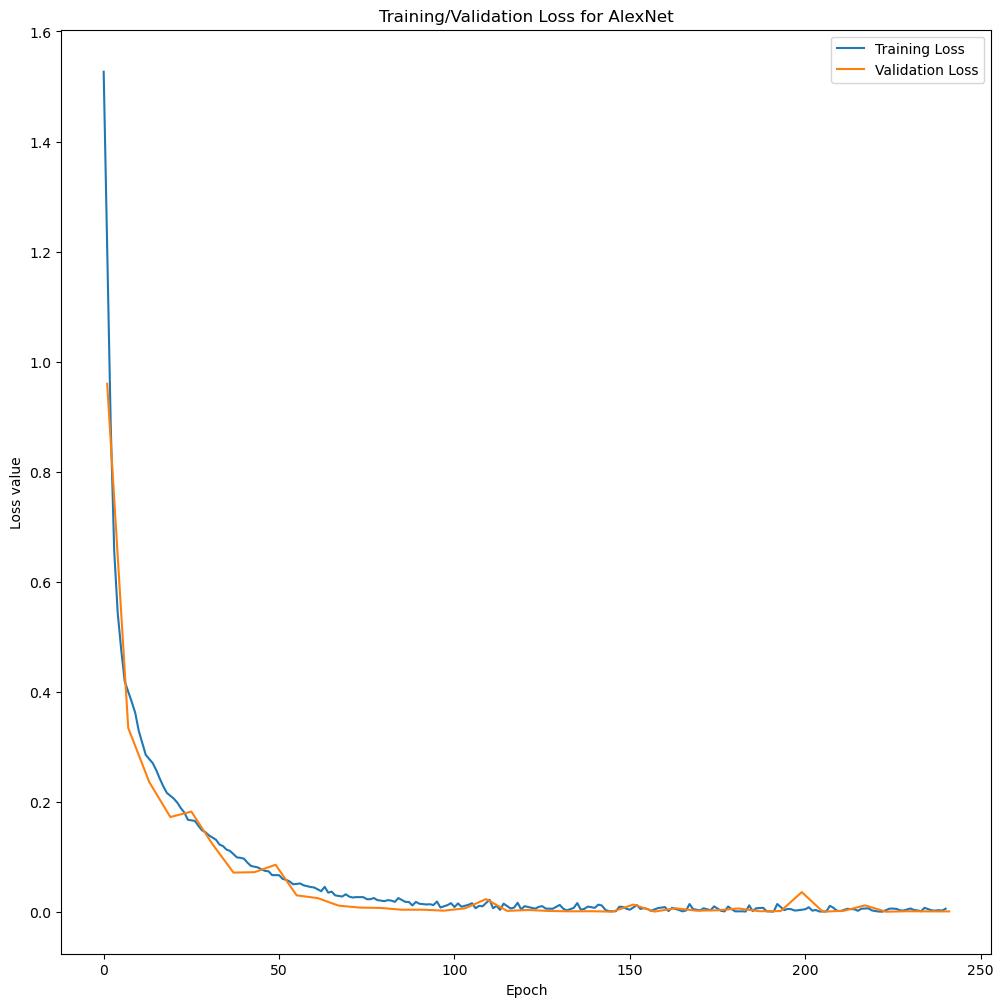

In [ ]:
#plot losses over epoch
ax = df.query("mode == 'train'")['loss'].plot()
df.query("mode == 'val'")['loss'].plot()
ax.legend(('Training Loss', 'Validation Loss'))
ax.set_title('Training/Validation Loss for AlexNet')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss value')

Text(0, 0.5, 'Accuracy value')

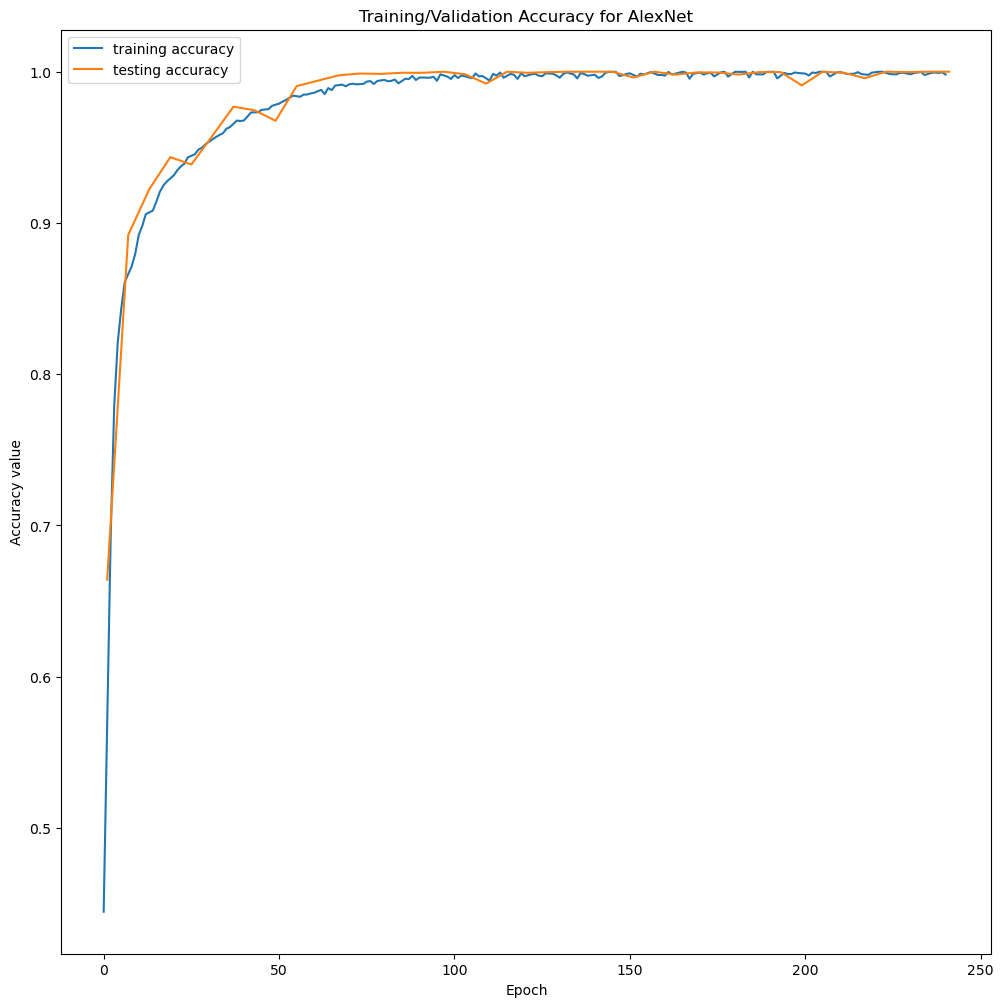

In [ ]:
ax  = df.query("mode == 'train'")['accuracy'].plot()
df.query("mode == 'val'")['accuracy'].plot()
ax.legend(('training accuracy', 'testing accuracy'))
ax.set_title('Training/Validation Accuracy for AlexNet')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy value')

In [ ]:
#saving logs on local machine
df.to_pickle('AlexNet_logs.pkl')